In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sim_functions import *

from tqdm import tqdm

from scipy.optimize import curve_fit

In [12]:
nx = 500
ny = 200
steps = 15000
output_stride = 500
profile_interval = 100

In [13]:
molecular_weights = np.array([1,80])
n_species = len(molecular_weights)
multiplier = 11

Bss = multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[1])
D_lbm = 1/Bss
print('Predict diffusion constant = ', D_lbm)

phi_1 = 0.78
phi_2 = phi_1 * molecular_weights[0]/molecular_weights[1]
phis = np.array([phi_1, phi_2])
phis = xp.array(phis)

predict_lambda = (phi_1 /3) * multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[0])
relaxation = predict_lambda/(1+predict_lambda/2)
viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
print('viscosity_kinematic = ',viscosity_kinematic)

Predict diffusion constant =  0.09147550817044595
viscosity_kinematic =  0.16482675552133974


In [14]:
vx = 0.003
v_top = xp.array([vx, 0])
c_top = xp.array([0.98,0.02])

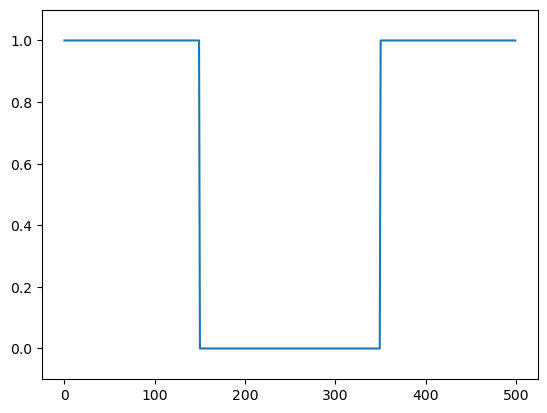

In [15]:
absorption_coefficient = 50

non_absorb_mask = xp.zeros(nx)
#non_absorb_mask[:nx//2] = True
non_absorb_mask[:] = True
non_absorb_mask[150:-150] = False
plt.plot(to_numpy(non_absorb_mask))
plt.ylim([-0.1, 1.1])

reflection_boundary = np.array([0, 0]) # which component has no-slip wall BC
b1 = xp.array([0,absorption_coefficient]) # 1 / absorption
b2 = xp.array([1, 1])
b3 = xp.array([0.98, 0]) # stable concentration (partial pressure)

bc_bottom = (b1, b2, b3, reflection_boundary)

In [16]:
lbm_config = lbm_parameters(
    nx=nx,
    ny=ny,
    steps=steps,
    output_interval=output_stride,
    molecular_weights=xp.array(molecular_weights),
    multiplier=multiplier,
    phis=xp.array(phis),
    v_top = v_top, # vx, vy
    c_top = c_top, # partial pressure
    bc_bottom = bc_bottom,
    non_absorb_mask=non_absorb_mask,
)

In [17]:
vx_ini = vx
total_pressure = 1
partial_pressure = xp.array([0.98, 0.02])

y_coord = xp.arange(ny)
velocity_profile = vx_ini * y_coord/ny

ux_s = xp.ones((n_species, nx, ny), dtype=xp.float32) * velocity_profile[None, None, :]
uy_s = xp.zeros((n_species, nx, ny), dtype=xp.float32)

rho_s = xp.zeros((n_species, nx,ny))
for s in range(n_species):
    rho_s[s,:,:] = 3* partial_pressure[s] * xp.ones((nx,ny))

f = xp.zeros((n_species, 9, nx, ny), dtype=DTYPE)
feq = equilibrium(f, rho_s, lbm_config, ux_s, uy_s)
f = feq

f_cross_ini = feq[:, :, nx//2, :]

In [18]:
def main(f, lbm_config):
    velocity_field = []
    clip_history = []
    f_cross = []
    for step in tqdm(range(lbm_config.steps + 1)):
        if step % output_stride == 0:
            
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, lbm_config)
            ux_s = to_numpy(ux_s).astype(np.float32)
            uy_s = to_numpy(uy_s).astype(np.float32)
            velocity_field.append((ux_s, uy_s))
            plot_vector(to_numpy(ux_s[0]), to_numpy(uy_s[0]), step, zoom = 1/vx/15, skip = nx//30, save = True)
            save_concentration_frames(f, step, lbm_config)
            #plt.plot(to_numpy(rho_s[1, :, 0]))
            #plt.show()

        if step == steps:
            break
        f, clipped = bgk_step(f, lbm_config, top_moving_left_intake_bottom_absorb)
        clip_history.append(clipped)
        if step % profile_interval == 0:
            f_cross.append(f[:, :, nx//2, :])
    f_cross = to_numpy(xp.array(f_cross))
    return np.array(velocity_field), np.array(clip_history), np.array(f_cross), to_numpy(f)

In [19]:
velocity_field,clip_history, f_cross, f_end = main(f, lbm_config)

100%|█████████▉| 15000/15001 [04:25<00:00, 56.58it/s]


(31, 2, 2, 500, 200)
(31, 200)


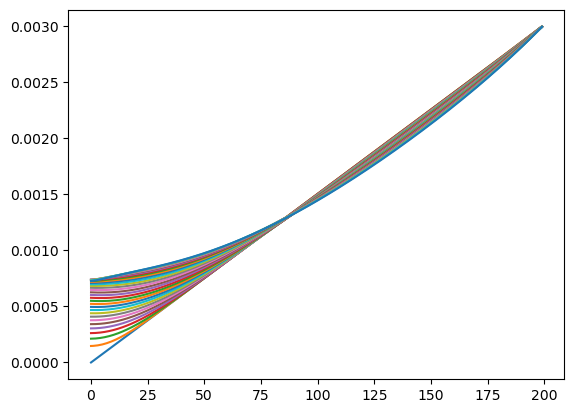

In [23]:
print(velocity_field.shape)
# frames, components, species, nx, ny

vx_profile = velocity_field[:, 0, 0, nx//2, :]
print(vx_profile.shape)
for i in range(vx_profile.shape[0]):
    plt.plot(vx_profile[i, :])

(150, 2, 9, 200)
(149,)


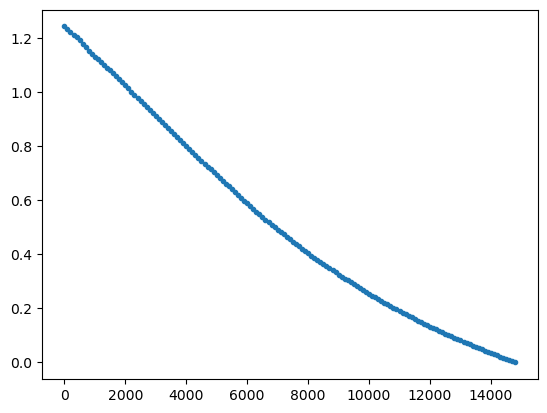

In [24]:
err = []
print(f_cross.shape)
for i in range(f_cross.shape[0]-1):
    error = np.sum(np.abs(f_cross[-i-1] - f_cross[-1]))
    err.append(error)
err = np.array(err)
print(err.shape)
plt.plot(np.arange(len(err))*profile_interval, err[::-1], marker = ".")

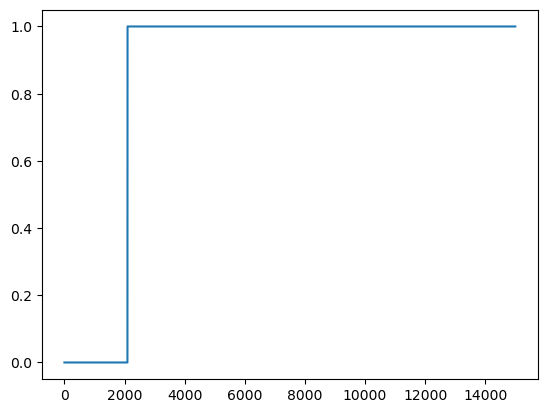

In [25]:
plt.plot(clip_history)